# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [34]:
# Input parameters
# https://github.com/facebookarchive/fb.resnet.torch/issues/180
cifar_mean=tuple(x/255.0 for x in [125.3, 123.0, 113.9])
cifar_std=tuple(x/255.0 for x in [63.0, 62.1, 66.7])

IS_GPU = torch.cuda.is_available()
N_EPOCHS = 3
LEARNING_RATE = 1e-4
IMAGE_MEANS = cifar_mean
IMAGE_STDS = cifar_std
BATCH_SIZE=5
PRINT_STEP=250 #samples


In [3]:
# Define transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(IMAGE_MEANS, IMAGE_STDS)])


# Create training set and define training dataloader
trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True, 
                                        download=True, 
                                        transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

# Create test set and define test dataloader
testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=BATCH_SIZE,
                                         shuffle=False)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [8]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.clip(np.rot90(image.T, k=3), 0, 1)) # I had to add np.clip here
        plt.show()

cat


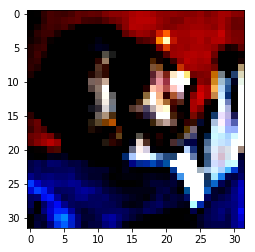

ship


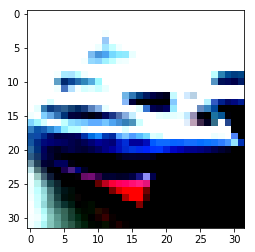

ship


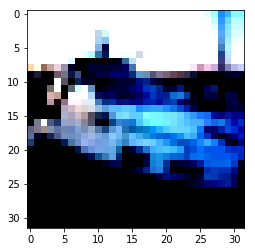

plane


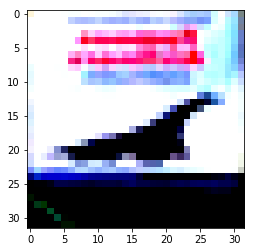

frog


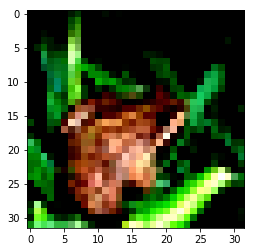

In [9]:
# Explore data
show5(testloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [18]:
## YOUR CODE HERE ##
# The following reference has been consulted as helper: https://github.com/kuangliu/pytorch-cifar/blob/master/models/vgg.py
import torch
import torch.nn as nn


layers_vgg11=[64, 
              'MaxPool', 
              128, 
              'MaxPool', 
              256, 
              256, 
              'MaxPool', 
              512, 
              512, 
              'MaxPool', 
              512, 
              512, 
              'MaxPool'
             ]

class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        
        conv_layers = []
        in_channels = 3
        for x in layers_vgg11:
            if x == 'MaxPool':
                conv_layers.extend([nn.MaxPool2d(kernel_size=2, stride=2)])
            else:
                conv_layers.extend([nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)])
                in_channels = x
                
        conv_layers.extend([nn.AvgPool2d(kernel_size=1, stride=1)])
        self.features=nn.Sequential(*conv_layers)
        
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [19]:
## YOUR CODE HERE ##
net = VGG11()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [36]:
## YOUR CODE HERE ##    
def train_network(trainloader, net, loss, optimizer, is_gpu, n_epochs=2, print_step=2000):
    loss_history = []
    if is_gpu:
        net = net.cuda()
        net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    
    for epoch in range(n_epochs): 

        running_loss = 0.0
        net.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            if is_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % print_step == 0 and i!=0:
                loss_history.append(running_loss / print_step)
                print(f"Epoch: {epoch + 1}, Step: {i}, Loss: {running_loss / print_step}")
                running_loss = 0.0
    return loss_history
    
loss_history=train_network(trainloader, net, criterion, optimizer, IS_GPU, n_epochs=N_EPOCHS, print_step=PRINT_STEP)

Epoch: 1, Step: 250, Loss: 0.8258278978168965
Epoch: 1, Step: 500, Loss: 0.8619449968636036
Epoch: 1, Step: 750, Loss: 0.8237549235522748
Epoch: 1, Step: 1000, Loss: 0.8298499592542649
Epoch: 1, Step: 1250, Loss: 0.825163671374321
Epoch: 1, Step: 1500, Loss: 0.8437230507731438
Epoch: 1, Step: 1750, Loss: 0.8272837490439415
Epoch: 1, Step: 2000, Loss: 0.8467429358959198
Epoch: 1, Step: 2250, Loss: 0.8160374005883932
Epoch: 1, Step: 2500, Loss: 0.8817829216420651
Epoch: 1, Step: 2750, Loss: 0.8051914903745055
Epoch: 1, Step: 3000, Loss: 0.8514080947041511
Epoch: 1, Step: 3250, Loss: 0.865154478609562
Epoch: 1, Step: 3500, Loss: 0.811650943517685
Epoch: 1, Step: 3750, Loss: 0.7785584111511707
Epoch: 1, Step: 4000, Loss: 0.8562453107237816
Epoch: 1, Step: 4250, Loss: 0.8239292540997267
Epoch: 1, Step: 4500, Loss: 0.7738249661922455
Epoch: 1, Step: 4750, Loss: 0.8190739211142063
Epoch: 1, Step: 5000, Loss: 0.8260473743528127
Epoch: 1, Step: 5250, Loss: 0.7689818136096
Epoch: 1, Step: 5500, 

Plot the training loss (and validation loss/accuracy, if recorded).

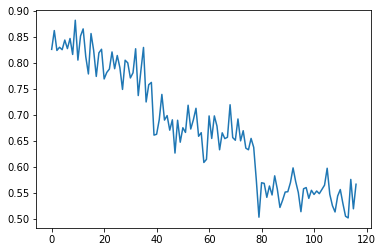

In [37]:
## YOUR CODE HERE ##
plt.plot(loss_history)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [40]:
def test_network(testloader, is_gpu, net):
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            if is_gpu:
                images, labels = images.cuda(), labels.cuda()
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network {100 * correct / total}%')

test_network(testloader, IS_GPU, net)

Accuracy of the network 78.95%


## Saving your model
Using `torch.save`, save your model for future loading.

In [33]:
## YOUR CODE HERE ##
torch.save(net.state_dict(), 'dl_model.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

**How does your model compare to Detectocorp's model?**
The model reached an accuracy of 78% which is 8% above Detectocorp's model, with accuracy of 70%

**How does it compare to the far more advanced solutions in the literature?**
Is is still far from SoTA results, which is above 90%, but still is a decent and simple network. 

**What did you do to get the accuracy you achieved?**

Here's the main parameters:
```
N_EPOCHS = 3
LEARNING_RATE = 1e-4
IMAGE_MEANS = cifar_mean
IMAGE_STDS = cifar_std
BATCH_SIZE=5
PRINT_STEP=250 #samples
```

- Model: A VGG11-like architecture has been used, similar to the following image ([reference](https://www.researchgate.net/figure/Figure-S1-Block-diagram-of-the-VGG11-architecture-Adapted-from-https-bitly-2ksX5Eq_fig1_336550999)):
![](https://www.researchgate.net/publication/336550999/figure/fig1/AS:814110748987402@1571110536721/Figure-S1-Block-diagram-of-the-VGG11-architecture-Adapted-from-https-bitly-2ksX5Eq.png)
The only difference was the classifier layer had only one hidden layer with 512 units.

- Loss Function: Adam with a learning rate of 1e-4

- Transform: No data augmentation has been applied, but the data has been normalized using CIFAR stats

**Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?**

Some things for improving accuracy:
- Try other architectures
- Data augmentation, mixup
- Some callbacks like LRFinder and learning rate scheduler
- More epochs and create a validation set

## References
The following references were consulted as helper for this project:
- https://github.com/kuangliu/pytorch-cifar
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).